In [71]:
import os
import librosa
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# Sequential: Katmanları sıralı şekilde eklemeye yarar.
# Dense: Tam bağlantılı sinir ağı katmanı.
# Dropout: Aşırı öğrenmeyi önlemek için nöronları rastgele devre dışı bırakır.


In [72]:
# GPU Yapılandırması (Opsiyonel: GPU ayarlarınızı uyarlayabilirsiniz)
physical_devices = tf.config.list_physical_devices('GPU')  # Sistemdeki mevcut GPU aygıtlarını listeler.
if physical_devices:
    # Eğer GPU varsa, GPU bilgilerini yazdırır.
    print(f"GPU kullanılıyor: {tf.config.experimental.get_device_details(physical_devices[0])}")
else:
    # Eğer GPU yoksa, CPU kullanılacağını belirtir.
    print("GPU bulunamadı, CPU kullanılıyor.")


GPU bulunamadı, CPU kullanılıyor.


In [73]:
# MFCC özellik çıkarma fonksiyonu
def extract_mfcc_features(audio, sample_rate):
    # MFCC (Mel-Frekans Kepstral Katsayıları) çıkarımı yapar
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)  # 13 MFCC katsayısı hesaplanır.
    
    # Delta MFCC'ler (zaman içindeki değişiklikleri temsil eder) hesaplar
    delta_mfccs = librosa.feature.delta(mfccs)
    
    # İkinci dereceden Delta MFCC'ler (değişimin değişikliği) hesaplar
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # MFCC, Delta ve İkinci Delta özellikleri birleştirir
    features = np.concatenate([mfccs, delta_mfccs, delta2_mfccs], axis=0)
    
    # Özelliklerin ortalamaları hesaplae (her bir katsayının zaman içindeki ortalaması).
    features_mean = np.mean(features, axis=1)
    
    # Özelliklerin standart sapmaları hesaplar (her bir katsayının değişkenliği).
    features_std = np.std(features, axis=1)
    
    # Ortalamalar ve standart sapmalar birleştirilerek sonuç döndürür.
    return np.concatenate([features_mean, features_std])


In [74]:
# Veri artırma (Data Augmentation) fonksiyonları
def augment_audio(audio, sample_rate):
    # Gürültü ekleme
    noise = np.random.normal(0, 0.005, audio.shape)  # Rastgele düşük seviyeli gürültü oluşturur
    audio_noisy = audio + noise  # Orijinal sesle gürültü birleştirilir.

    # Zaman ölçeklendirme (Time stretch)
    audio_stretched = librosa.effects.time_stretch(audio, rate=1.1)  # Sesin oynatma hızı %10 artırır

    # Ton kaydırma (Pitch shift)
    audio_shifted = librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=2)  # Ses tonunda 2 yarım perde artış yapar

    # Değiştirilmiş seslerin bir listesini döndürür.
    return [audio_noisy, audio_stretched, audio_shifted]


In [75]:

# Veri kümesi yolları ve başlangıç ayarları
dataset_folder = "dataset/train"  # Veri kümesinin bulunduğu klasörün yolu
voices_data = []  # Ses dosyaları için boş bir liste 
labels_data = []  # Etiketler için boş bir liste 

In [76]:
# Veri kümesi üzerinde veri artırma (augmentation) işlemi
for root, dirs, files in os.walk(dataset_folder):  # Dataset klasöründeki tüm dosyalar arasında gezer
    for file in files:
        if file.endswith(".wav"):  # Sadece '.wav' uzantılı ses dosyalarını işler.
            print(file)  # İşlenen dosya ismini yazdırır.
            file_path = os.path.join(root, file)  # Dosyanın tam yolunu oluşturur.
            audio, sample_rate = librosa.load(file_path, sr=None)  # Ses dosyasını yükler (orijinal örnekleme oranında).

            # Orijinal sesin özelliklerini çıkarır.
            features = extract_mfcc_features(audio, sample_rate)  # MFCC özelliklerini hesaplar.
            voices_data.append(features)  # Özellikleri listeye ekler.
            label = os.path.basename(root).split("_")[0]  # Klasör ismine göre etiketi belirler.
            labels_data.append(label)  # Etiketi listeye ekler.

            # Veri artırma (augmentation) işlemiyle oluşturulan sesleri işler.
            for augmented_audio in augment_audio(audio, sample_rate):  # Gürültü ekleme, zaman ölçeklendirme ve ton kaydırma.
                augmented_features = extract_mfcc_features(augmented_audio, sample_rate)  # Yeni seslerden MFCC özelliklerini çıkarır.
                voices_data.append(augmented_features)  # Özellikleri listeye ekler.
                labels_data.append(label)  # Aynı etiketi ekler.


mehmet_patch_1.wav
mehmet_patch_10.wav
mehmet_patch_11.wav
mehmet_patch_12.wav
mehmet_patch_13.wav
mehmet_patch_14.wav
mehmet_patch_15.wav
mehmet_patch_16.wav
mehmet_patch_17.wav
mehmet_patch_18.wav
mehmet_patch_19.wav
mehmet_patch_2.wav
mehmet_patch_20.wav
mehmet_patch_21.wav
mehmet_patch_22.wav
mehmet_patch_23.wav
mehmet_patch_24.wav
mehmet_patch_25.wav
mehmet_patch_26.wav
mehmet_patch_27.wav
mehmet_patch_28.wav
mehmet_patch_29.wav
mehmet_patch_3.wav
mehmet_patch_30.wav
mehmet_patch_31.wav
mehmet_patch_32.wav
mehmet_patch_33.wav
mehmet_patch_34.wav
mehmet_patch_35.wav
mehmet_patch_36.wav
mehmet_patch_37.wav
mehmet_patch_38.wav
mehmet_patch_39.wav
mehmet_patch_4.wav
mehmet_patch_40.wav
mehmet_patch_41.wav
mehmet_patch_42.wav
mehmet_patch_43.wav
mehmet_patch_44.wav
mehmet_patch_45.wav
mehmet_patch_46.wav
mehmet_patch_47.wav
mehmet_patch_48.wav
mehmet_patch_49.wav
mehmet_patch_5.wav
mehmet_patch_50.wav
mehmet_patch_51.wav
mehmet_patch_52.wav
mehmet_patch_53.wav
mehmet_patch_54.wav
mehme

In [77]:
# Veriyi numpy dizilerine dönüştür
voices_data = np.array(voices_data)  # Ses özelliklerini numpy dizisine dönüştür.
labels_data = np.array(labels_data)  # Etiketleri numpy dizisine dönüştür.

# Etiketleri kodla (Encode labels)
label_encoder = LabelEncoder()  # LabelEncoder nesnesi oluştur.
labels_data = label_encoder.fit_transform(labels_data)  # Etiketleri sayısal değerlere dönüştür.

# Veri kümesini böl (Split dataset)
X_train, X_test, y_train, y_test = train_test_split(
    voices_data, labels_data, test_size=0.2, random_state=42
)  # Veriyi %80 eğitim ve %20 test olarak ayır.


In [78]:
# Etiket kodlayıcıyı (Label Encoder) kaydet
with open("label_encoder.pkl", "wb") as file:  # "label_encoder.pkl" adında bir dosya oluşturur.
    pickle.dump(label_encoder, file)  # LabelEncoder nesnesini dosyaya yaz (pickle kullanarak).

In [79]:
from tensorflow.keras import Input

# TensorFlow Modeli
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # İlk katman için girdi boyutunu belirtir.
    Dense(128, activation='relu'),  # Tam bağlantılı katman, ReLU aktivasyon fonksiyonu ile.
    Dropout(0.3),  # Aşırı öğrenmeyi önlemek için %30 Dropout.
    Dense(128, activation='relu'),  # İkinci tam bağlantılı katman.
    Dropout(0.3),  # Aşırı öğrenmeyi önlemek için %30 Dropout.
    Dense(len(np.unique(y_train)), activation='softmax')  # Çıkış katmanı: Çok sınıflı sınıflandırma için softmax aktivasyonu.
])


In [80]:
# Modeli derle (Compile the model)
model.compile(
    optimizer='adam',  # Optimizasyon algoritması olarak Adam kullanır.
    loss='sparse_categorical_crossentropy',  # Çok sınıflı sınıflandırma için kayıp fonksiyonu.
    metrics=['accuracy']  # Değerlendirme için doğruluk (accuracy) metriği kullanır
)



In [81]:
# Modeli eğit (Train the model)
history = model.fit(
    X_train,  # Eğitim veri kümesindeki özellikler.
    y_train,  # Eğitim veri kümesindeki etiketler.
    epochs=100,  # Eğitim sırasında modelin veriyi 100 kez (epoch) görmesi sağlar.
    batch_size=8,  # Her güncellemede 8 örnek kullanılır (mini-batch boyutu).
    validation_split=0.2,  # Verinin %20'si doğrulama (validation) için ayrır.
    verbose=1  # Eğitim sırasında çıktıların detaylı şekilde gösterilmesi (1: ayrıntılı, 0: sessiz).
)



Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3063 - loss: 14.7286 - val_accuracy: 0.7255 - val_loss: 1.5253
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4859 - loss: 4.4436 - val_accuracy: 0.8039 - val_loss: 0.8646
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6579 - loss: 1.6158 - val_accuracy: 0.8889 - val_loss: 0.3165
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7677 - loss: 0.7768 - val_accuracy: 0.8954 - val_loss: 0.2634
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8080 - loss: 0.5983 - val_accuracy: 0.9216 - val_loss: 0.1838
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8321 - loss: 0.4420 - val_accuracy: 0.9542 - val_loss: 0.1297
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8885 - loss: 0.2920 - val_accuracy: 0.9346 - val_loss: 0.1394
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9392 - loss: 0.1811 - val_accuracy: 0.9739 - 

In [82]:
# Modeli değerlendirme (Evaluate the model)
y_pred = np.argmax(model.predict(X_test), axis=1)  # Modelin tahminlerini al ve sınıf indekslerini belirle.
accuracy = accuracy_score(y_test, y_pred)  # Test veri kümesindeki doğruluk oranını hesapla.
print(f"Accuracy: {accuracy}")  # Modelin doğruluğunu yazdır.

# Modeli kaydet (Save the model)
model.save("voice_classifier_model.h5")  # Eğitilmiş modeli bir .h5 dosyasına kaydet.

# Sınıflandırma Raporu ve Karışıklık Matrisi (Classification Report and Confusion Matrix)
print("Classification Report:\n", classification_report(y_test, y_pred))  # Sınıflandırma raporunu yazdır.
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))  # Karışıklık matrisini yazdır.


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        36
           2       1.00      1.00      1.00        62
           3       1.00      1.00      1.00        52

    accuracy                           1.00       191
   macro avg       1.00      1.00      1.00       191
weighted avg       1.00      1.00      1.00       191

Confusion Matrix:
 [[41  0  0  0]
 [ 0 36  0  0]
 [ 0  0 62  0]
 [ 0  0  0 52]]


In [83]:
import matplotlib.pyplot as plt

# Eğitim ve Doğrulama Doğruluğunu Çizdirme Fonksiyonu
def plot_accuracy(history):
    # Eğitim doğruluğunu (accuracy) çizer
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    # Doğrulama doğruluğunu (validation accuracy) çizer
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    # X eksenine "Epochs" etiketi ekler (modelin kaç eğitim döngüsü geçirdiğini ifade eder)
    plt.xlabel('Epochs')
    # Y eksenine "Accuracy" etiketi eklenir (doğruluk oranı gösterilir)
    plt.ylabel('Doğruluk')
    # Grafik için bir başlık eklenir
    plt.title('Eğitim ve Doğrulama Doğruluğu')
    # Grafik üzerinde açıklamalar (etiketler) ekler
    plt.legend()
    # Grafiği ekranda gösterir
    plt.show()

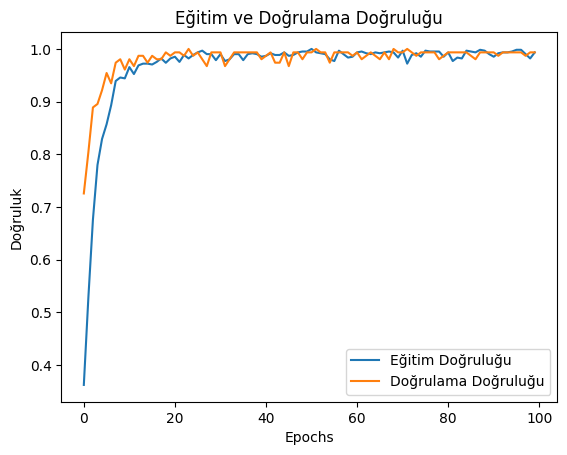

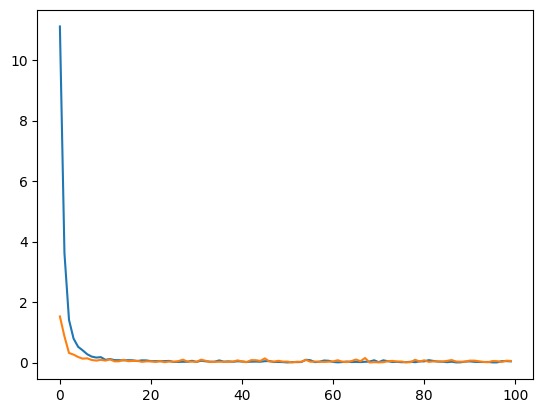

In [85]:
# Eğitim ve doğrulama doğruluğu grafiği çizilir
plot_accuracy(history)
# Eğitim ve doğrulama kaybı grafiği çizilir
plot_loss(history)


In [86]:
from tensorflow.keras.models import load_model

# Test için MFCC özellik çıkarım fonksiyonu
def extract_mfcc_features_test(audio_file):
    # Ses dosyasını yükle
    audio, sample_rate = librosa.load(audio_file, sr=None)
    # MFCC (Mel-Frekans Kepstral Katsayıları) özelliklerini çıkar
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    # MFCC'nin birinci türevini (delta) çıkar
    delta_mfccs = librosa.feature.delta(mfccs)
    # MFCC'nin ikinci türevini (delta2) çıkar
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    # Tüm özellikleri birleştir
    features = np.concatenate([mfccs, delta_mfccs, delta2_mfccs], axis=0)
    # Özelliklerin ortalama ve standart sapmasını hesapla
    features_mean = np.mean(features, axis=1)
    features_std = np.std(features, axis=1)
    return np.concatenate([features_mean, features_std])

# Kaydedilmiş modeli yükleme
model_path = "voice_classifier_model_1.h5"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model {model_path} yolunda bulunamadı. Model eğitim scriptini çalıştırdığınızdan emin olun.")

model = load_model(model_path)

# Label encoder (etiket kodlayıcı) yükleme
label_encoder_path = "label_encoder.pkl"
if not os.path.exists(label_encoder_path):
    raise FileNotFoundError(f"Etiket kodlayıcı {label_encoder_path} yolunda bulunamadı. Eğitim sırasında kaydettiğinizden emin olun.")

with open(label_encoder_path, "rb") as file:
    label_encoder = pickle.load(file)

# Yeni bir ses dosyasını test etme fonksiyonu
def test_audio_classification(audio_file):
    # Ses dosyasından MFCC özelliklerini çıkarır
    features = extract_mfcc_features_test(audio_file)
    features = np.expand_dims(features, axis=0)  # Batch boyutunu ekler
    # Model ile sınıflandırma tahmini yapma
    predictions = model.predict(features)
    # En olası sınıfı etikete dönüştürme
    predicted_label = label_encoder.inverse_transform([np.argmax(predictions)])
    # Tahmin güvenini (olasılık) hesaplama
    confidence = np.max(predictions) * 100
    return predicted_label[0], confidence

# Modeli yeni bir ses dosyasında test et
test_audio_path = "SesTanımaProjesi-SesBirleştirme/voice_data/zeynep_deneme1.wav"  # Test ses dosyasının yolunu güncelleyin
if not os.path.exists(test_audio_path):
    raise FileNotFoundError(f"Test ses dosyası {test_audio_path} yolunda bulunamadı.")

predicted_label, confidence = test_audio_classification(test_audio_path)
print(f"Tahmin Edilen Etiket: {predicted_label}")
print(f"Güven: %{confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Tahmin Edilen Etiket: zeynep
Güven: %100.00


In [48]:
2+2

4